# Areal Project

Challenge solved by:
- Phan Anh Vu: (phanav)
- Mohamed Salem Messoud: (mdsalem17)


<div>
    <h2>Introduction </h2>
     <br>
Aerial imagery has been a primary source of geographic data for quite a long time. With technology progress, aerial imagery became really practical for remote sensing : the science of obtaining information about an object, area or phenomenon.
Nowadays, there are many uses of image recognition spanning from robotics/drone vision to autonomous driving vehicules or face detection.
<br>
In this challenge, we will use pre-processed data, coming from landscape images. The goal is to learn to differentiate common and uncommon landscapes such as a beach, a lake or a meadow.
    Data comes from part of the data set (NWPU-RESISC45) originally used in <a href="https://arxiv.org/pdf/1703.00121.pdf?fbclid=IwAR16qo-EX_Z05ZpxvWG8F-oBU0SlnY-3BPCWBVVOGPyJcVy7BBqCKjnsvJo">Remote Sensing Image Scene Classification</a>. This data set contains 45 categories while we only kept 13 out of them.

References and credits: 
Yuliya Tarabalka, Guillaume Charpiat, Nicolas Girard for the data sets presentation.<br>
Gong Cheng, Junwei Han, and Xiaoqiang Lu, for the original article on the chosen data set.
</div>

### Requirements 

The next cell will install all the required dependencies on your computer. You should consider replacing pip with pip3 if pip is related to python2.7 on your computer, or comment it if you already have the dependencies/are running in the docker of the challenge (runnable with the name areal/codalab:pytorch if you know how to run a docker).

In [1]:
#Reminder: You should install TensorFLow and Keras, if you don't have it
#!pip install tensorflow==2.3.1
#!pip install keras

In [2]:
#!pip install --user -r requirements.txt

In [3]:
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import os
import sys
from pathlib import Path
import shutil
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


In [4]:
root_dir = Path("..")

In [5]:
str_ = str(os.getcwd())
print(str_)
starting_dir = Path(str_)
print(root_dir)
starting_dir = root_dir.joinpath("starting_kit")
print(starting_dir)
if str_.endswith('starting_kit'):
    str_ = str_[:-len('starting_kit')]
print(str_)

/Users/md_76s/Desktop/Files/starting_kit
..
../starting_kit
/Users/md_76s/Desktop/Files/


In [6]:
#root_dir = Path("/content/drive/MyDrive/Education/Master Informatique IA Computer Science AI Paris Saclay/AI/OPT9 Datacamp/TP5 Aerial")
root_dir = Path(str_)

starting_dir = root_dir.joinpath("starting_kit")
os.chdir(starting_dir)

print(os.listdir(root_dir))
print(os.listdir(starting_dir))

['.DS_Store', 'Bin', 'readme.md', 'public_data', 'starting_kit', 'image_data', 'tf_image_data']
['scoring_output', 'tensorflow_model.ipynb', '.DS_Store', 'requirements.txt', 'sample_result_submissionAreal_valid.predict', 'sample_result_submissionAreal_test.predict', 'fastai_model.ipynb', 'sample_code_submission', 'sample_result_submission', 'models', 'README.md', 'sample_data', 'logo.jpg', 'submissions', 'sample_result_submissionAreal_train.predict', '.ipynb_checkpoints', 'scoring_program', 'BasicCNN.ipynb', 'ingestion_program']


In [7]:
model_dir = 'sample_code_submission'
result_dir = 'sample_result_submission/'
problem_dir = 'ingestion_program/'
score_dir = 'scoring_program/'

In [8]:
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);

<div>
    <h1> 1) Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
</div>

In [9]:
sample_data_dir = starting_dir.joinpath("sample_data")
public_data_dir = root_dir.joinpath("public_data")
data_name = 'Areal'

In [10]:
from ingestion_program import data_converter

<h2 style="color:red " >Warning</h2>

<p style="font-style:italic"> In case you want to load the full data </p> 
Files being big, your computer needs to have enough space available in your RAM. It should take about 3-4GB while loading and 1.5GB in the end.

In [11]:
from ingestion_program.data_io import read_as_df
data = read_as_df(str(sample_data_dir)  + '/' + data_name)

Reading /Users/md_76s/Desktop/Files/starting_kit/sample_data/Areal_train from AutoML format
Number of examples = 65
Number of features = 49152
        Class
0       beach
1   chaparral
2       cloud
3      desert
4      forest
5      island
6        lake
7      meadow
8    mountain
9       river
10        sea
11   snowberg
12    wetland
Number of classes = 13


In [12]:
data.head()

,pixel_1_1_R,pixel_1_1_G,pixel_1_1_B,pixel_1_2_R,pixel_1_2_G,pixel_1_2_B,pixel_1_3_R,pixel_1_3_G,pixel_1_3_B,pixel_1_4_R,...,pixel_128_126_R,pixel_128_126_G,pixel_128_126_B,pixel_128_127_R,pixel_128_127_G,pixel_128_127_B,pixel_128_128_R,pixel_128_128_G,pixel_128_128_B,target
0,145,145,121,113,113,89,73,75,53,65,...,191,164,134,196,169,139,202,175,145,desert
1,193,168,138,191,166,136,201,176,146,194,...,196,171,140,197,172,141,201,176,145,desert
2,83,86,67,65,68,49,73,78,58,78,...,115,110,91,115,107,88,141,133,114,meadow
3,16,52,48,15,51,47,15,52,45,15,...,65,83,61,58,75,56,68,85,66,river
4,60,79,47,80,99,67,62,81,51,45,...,182,197,202,121,135,144,120,137,147,mountain


In [13]:
data.describe()

,pixel_1_1_R,pixel_1_1_G,pixel_1_1_B,pixel_1_2_R,pixel_1_2_G,pixel_1_2_B,pixel_1_3_R,pixel_1_3_G,pixel_1_3_B,pixel_1_4_R,...,pixel_128_125_B,pixel_128_126_R,pixel_128_126_G,pixel_128_126_B,pixel_128_127_R,pixel_128_127_G,pixel_128_127_B,pixel_128_128_R,pixel_128_128_G,pixel_128_128_B
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,...,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,96.630769,102.030769,93.676923,97.230769,102.661538,94.323077,94.353846,99.584615,91.230769,93.076923,...,98.015385,99.307692,103.800000,94.523077,97.369231,101.738462,93.076923,95.800000,100.323077,91.600000
std,63.041794,52.057051,52.828765,64.983356,53.971427,54.017679,63.980815,53.380091,53.738594,64.282168,...,58.560463,63.085241,54.084194,55.020765,60.896575,50.817467,51.335389,55.726509,43.865956,43.464713
min,13.000000,14.000000,14.000000,6.000000,13.000000,12.000000,9.000000,13.000000,11.000000,11.000000,...,12.000000,10.000000,15.000000,9.000000,14.000000,19.000000,14.000000,17.000000,22.000000,18.000000
25%,53.000000,63.000000,52.000000,44.000000,64.000000,49.000000,46.000000,60.000000,48.000000,45.000000,...,60.000000,55.000000,63.000000,58.000000,53.000000,60.000000,56.000000,53.000000,64.000000,55.000000
50%,82.000000,88.000000,85.000000,80.000000,96.000000,88.000000,74.000000,87.000000,84.000000,77.000000,...,90.000000,73.000000,90.000000,74.000000,74.000000,97.000000,86.000000,76.000000,96.000000,92.000000
75%,141.000000,137.000000,135.000000,139.000000,145.000000,136.000000,136.000000,140.000000,136.000000,136.000000,...,121.000000,152.000000,141.000000,128.000000,138.000000,144.000000,130.000000,135.000000,137.000000,132.000000
max,239.000000,240.000000,245.000000,237.000000,239.000000,242.000000,239.000000,238.000000,243.000000,240.000000,...,255.000000,240.000000,249.000000,254.000000,235.000000,245.000000,254.000000,232.000000,212.000000,218.000000


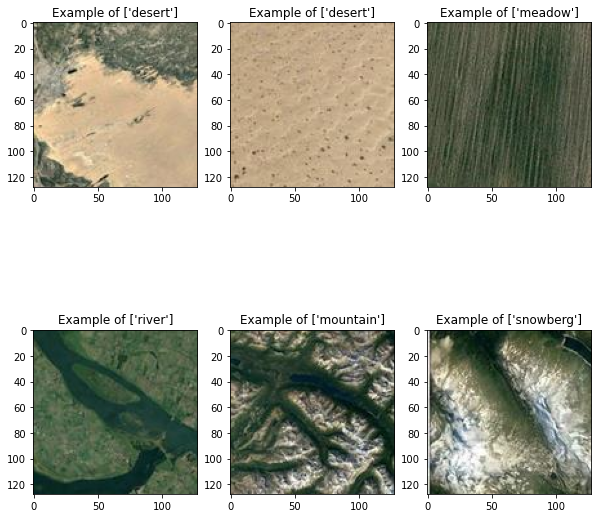

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

num_toshow = 6
fig, _axs = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

for i in range(num_toshow):
    img = data.iloc[i].values[:-1].reshape(128,128,3)
    label = data.iloc[i].values[-1:]
    axs[i].set_title('Example of {}'.format(label))
    axs[i].imshow(img.astype(float) / 255)

plt.show()

In [15]:
print(data.iloc[:, -1:])
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

      target
0     desert
1     desert
2     meadow
3      river
4   mountain
..       ...
60    island
61    island
62      lake
63     beach
64    forest

[65 rows x 1 columns]


In [16]:
print(X.shape, y.shape)

(65, 49152) (65, 1)


## 2) Preprocessing and Preparing Images

### Importing the full dataset

<h2 style="color:red " >Warning</h2>

<p style="font-style:italic"> Here we are loading the entire data </p> 
This time, also, still make sure that your RAM has at least 2-3GB available.

In [17]:
from ingestion_program.data_manager import DataManager
D = DataManager(data_name, str(public_data_dir), replace_missing=False, verbose=True)
print(D)

Info file found : /Users/md_76s/Desktop/Files/public_data/Areal_public.info
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_feat.type
[+] Success in  0.00 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_train.data
[+] Success in 238.86 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_train.solution
[+] Success in  0.03 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_valid.data
[+] Success in 117.10 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_valid.solution
[+] Success in  0.01 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_test.data
[+] Success in 118.31 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_test.solution
[+] Success in  0.00 sec
DataManager : Areal
info:
	usage = Sample dataset Areal data
	name = areal
	task = multiclass.classification
	target_type = Categorical
	feat_type = Numerical
	metric = accuracy
	time_budget = 12000
	feat_num = 4

In [18]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']

In [19]:
print(X_train.shape, Y_train.shape)
print(Y_train[:5])

(5200, 49152) (5200, 1)
[[5]
 [0]
 [0]
 [1]
 [0]]


[0]


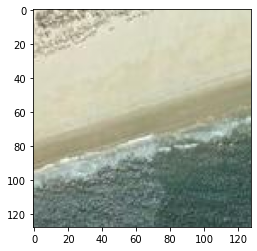

In [20]:
sample_idx = 4
plt.imshow(X_train[sample_idx].reshape(128,128,3).astype(float) / 255)
print(Y_train[sample_idx])

Labels codes: \
0       beach
1   chaparral
2       cloud
3      desert
4      forest
5      island
6        lake
7      meadow
8    mountain
9       river
10        sea
11   snowberg
12    wetland

In [21]:
label_code = 'beach chaparral cloud desert forest island lake meadow mountain river sea snowberg wetland'.split(' ')
image_dir = root_dir.joinpath("image_data")
data_dir = root_dir.joinpath("tf_image_data")
train_image_dir = image_dir.joinpath('train')
valid_image_dir = image_dir.joinpath('valid')
test_image_dir = image_dir.joinpath('test')
models_dir = starting_dir.joinpath("models")


### Training dataset into directory

We will save the input as image files. We have to structure our training data folder in a way that keras.preprocessing can work efficiently. The dataset contains 13 sub-directories, one per class. It is an inefficient way, but the easiest way to use tensorflow library.

```
tf_image_data/
     0/    1/     2/     3/
     4/    5/     6/     7/
     8/    9/    10/    11/
    12/
```

more about keras.preprocessing from directory here https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [68]:

def save_train_array_as_image(arrays, labels, output_dir):
    idx = 0
    labels_list = np.unique(labels)
    for label in labels_list:
        label_dir = output_dir.joinpath(str(label))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
    for array, label in zip(arrays, labels):
        img = array.reshape(128, 128, 3)
        label_idx = label[0]
        plt.imsave(output_dir.joinpath(str(label[0])).joinpath(
            f"index_{idx}.jpg"), img)
        idx+=1
  
if not os.path.exists(data_dir):  
    os.makedirs(data_dir)
    save_train_array_as_image(X_train, Y_train, data_dir)

print(os.listdir(data_dir))


['.DS_Store', '9', '0', '11', '7', '6', '1', '10', '8', '4', '3', '12', '2', '5']


In [69]:
labels = np.unique(Y_train)
print(labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [25]:
data_dir = pathlib.Path(data_dir)

We make sure that there are 5200 images available

In [26]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5200


We verify the content of some classes

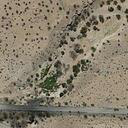

In [27]:
zeros = list(data_dir.glob('1/*'))
PIL.Image.open(str(zeros[0]))

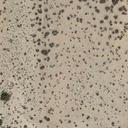

In [28]:
PIL.Image.open(str(zeros[1]))

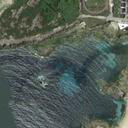

In [29]:
onces = list(data_dir.glob('0/*'))
PIL.Image.open(str(onces[0]))

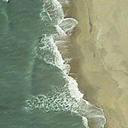

In [30]:
PIL.Image.open(str(onces[1]))

### Dataset creation

We define some parameters for the loader: the batch_size, the image height and width

In [31]:
batch_size = 32
img_height = 128
img_width = 128

We are using a validation split. Let's use 80% of the images for training, and 20% for validation.

In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5200 files belonging to 13 classes.
Using 4160 files for training.


In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5200 files belonging to 13 classes.
Using 1040 files for validation.


We can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order. It is an array of string.


In [34]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']


Here we can see the first 9 images from the training dataset.



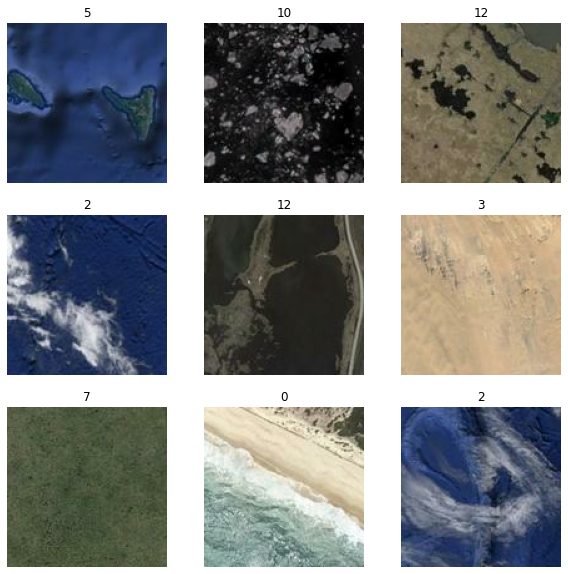

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


Let's use buffered prefetching so we allow later elements to be prepared while the current element is being processed, this improves latency and throughput.
It also interesting to keep the images in memory after they're loaded off disk during the first epoch.

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation - First Model (without data augmentation)
The RGB channel values are in the [0, 255] range. As we have seen in class (ML Projects Checklists – Part 2), this is not good for a neural network. We will standardize values to be in the [0, 1] range by using a Rescaling layer.
We have included the layer inside our model definition to simplify deployment.

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned yet.



In [38]:
num_classes = 13

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

We have choosen the optimizers.Adam optimizer and losses.SparseCategoricalCrossentropy loss function. 

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0

In [41]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
130/130 [==============================] - 110s 843ms/step - loss: 1.5966 - accuracy: 0.4474 - val_loss: 1.1436 - val_accuracy: 0.6000
Epoch 2/10
130/130 [==============================] - 106s 812ms/step - loss: 1.0172 - accuracy: 0.6481 - val_loss: 1.0481 - val_accuracy: 0.6365
Epoch 3/10
130/130 [==============================] - 103s 790ms/step - loss: 0.8532 - accuracy: 0.7058 - val_loss: 0.9762 - val_accuracy: 0.6481
Epoch 4/10
130/130 [==============================] - 114s 875ms/step - loss: 0.6881 - accuracy: 0.7611 - val_loss: 1.0037 - val_accuracy: 0.6635
Epoch 5/10
130/130 [==============================] - 119s 913ms/step - loss: 0.6129 - accuracy: 0.7935 - val_loss: 0.7737 - val_accuracy: 0.7462
Epoch 6/10
130/130 [==============================] - 117s 904ms/step - loss: 0.5003 - accuracy: 0.8337 - val_loss: 0.8534 - val_accuracy: 0.7000
Epoch 7/10
130/130 [==============================] - 115s 884ms/step - loss: 0.4438 - accuracy: 0.8507 - val_loss: 0.7055 -

#### Loss and Accuracy on the training and validation sets.

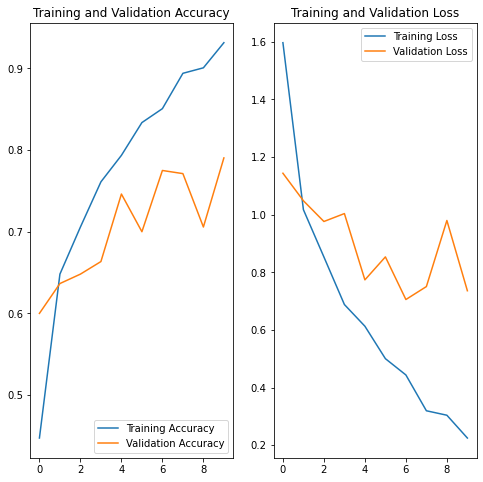

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 70% accuracy on the validation set. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of severe overfitting.

Let's implement data augmentation using experimental Keras Preprocessing Layers, we will introduce Dropout to the network, a form of regularization. More information about Dropout here (https://developers.google.com/machine-learning/glossary#dropout_regularization)

/\These can be included inside our model like with a layer, and run on the GPU.

### Model Creation - Second Model (with Data Augmentation)

We are going to augment our training data by applying Random Flips, Random Rotations, Random Zoom, Random Contrast.

Let's visualize what a few augmented examples look like after applying data augmentation to the same image several times:



In [43]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
  ]
)

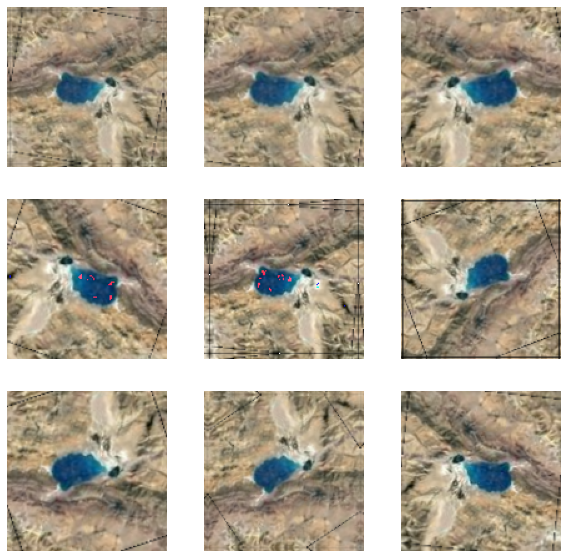

In [44]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

The new model will have layers that augment the training data, and having dropout factor for regularization purpose.

In [45]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)       

In [48]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
130/130 [==============================] - 132s 1s/step - loss: 1.7853 - accuracy: 0.3880 - val_loss: 1.4435 - val_accuracy: 0.4721
Epoch 2/15
130/130 [==============================] - 132s 1s/step - loss: 1.1498 - accuracy: 0.6055 - val_loss: 1.1459 - val_accuracy: 0.5942
Epoch 3/15
130/130 [==============================] - 127s 977ms/step - loss: 1.0085 - accuracy: 0.6611 - val_loss: 1.1190 - val_accuracy: 0.6385
Epoch 4/15
130/130 [==============================] - 136s 1s/step - loss: 0.9098 - accuracy: 0.6909 - val_loss: 1.1933 - val_accuracy: 0.6077
Epoch 5/15
130/130 [==============================] - 136s 1s/step - loss: 0.8327 - accuracy: 0.7154 - val_loss: 1.0703 - val_accuracy: 0.6433
Epoch 6/15
130/130 [==============================] - 116s 894ms/step - loss: 0.7911 - accuracy: 0.7281 - val_loss: 0.9680 - val_accuracy: 0.6731
Epoch 7/15
130/130 [==============================] - 113s 867ms/step - loss: 0.7618 - accuracy: 0.7469 - val_loss: 1.0128 - val_accurac

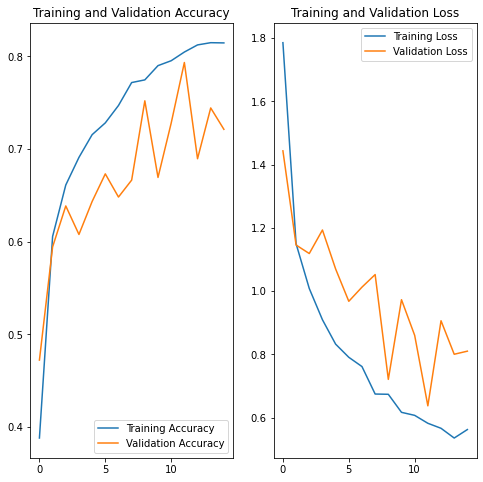

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on New Data

Let's predict on a single image to verify that our model performs well

In [109]:
img_name = !echo $data_dir/*/*index_10.jpg
img_name = str(img_name)
img_name = img_name[len(str(data_dir))+3:-2]
img_name

'6/index_10.jpg'

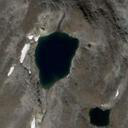

In [110]:
img_path = data_dir.joinpath(img_name)

PIL.Image.open(str(img_path))

In [111]:
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} which is {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], label_code[int(class_names[np.argmax(score)])], 100 * np.max(score))
)

This image most likely belongs to 6 which is lake with a 76.37 percent confidence.


In [112]:
def get_predictions(class_names, classes_index):
    predictions = []
    for i in classes_index:
        predictions.append(int(class_names[int(i)]))
    return predictions

In [53]:
_X_train = D.data['X_train']
_X_train = _X_train.reshape(_X_train.shape[0], img_height, img_width, 3)
_X_valid = D.data['X_valid']
_X_valid = _X_valid.reshape(_X_valid.shape[0], img_height, img_width, 3)
_X_test = D.data['X_test']
_X_test = _X_test.reshape(_X_test.shape[0], img_height, img_width, 3)

In [54]:
_train_classes = model.predict_classes(_X_train)
_valid_classes = model.predict_classes(_X_valid)
_test_classes  = model.predict_classes(_X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


the ```predict_classes``` function returns the index of the predicted class name in class_names attribute on these datasets, in string format.

In [55]:
print(_X_train.shape, _train_classes.shape)
print(_X_valid.shape, _valid_classes.shape)
print(_X_test.shape, _test_classes.shape)

(5200, 128, 128, 3) (5200,)
(1950, 128, 128, 3) (1950,)
(1950, 128, 128, 3) (1950,)


In [56]:
_Y_hat_train = get_predictions(class_names, _train_classes)
_Y_hat_valid = get_predictions(class_names, _valid_classes)
_Y_hat_test  = get_predictions(class_names, _test_classes)

In [57]:
print(_train_classes.shape, len(_Y_hat_train))
print(_valid_classes.shape, len(_Y_hat_valid))
print(_test_classes.shape, len(_Y_hat_test))

(5200,) 5200
(1950,) 1950
(1950,) 1950


#### Writing Predections

In [58]:
# m.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', _Y_hat_train)
write(result_name + '_valid.predict', _Y_hat_valid)
write(result_name + '_test.predict', _Y_hat_test)

!ls $result_name*

sample_result_submission/Areal_test.predict
sample_result_submission/Areal_train.predict
sample_result_submission/Areal_valid.predict


# Scoring the result

Obviously, since it is made with sample_data, which has too few samples, results won't be really good

In [59]:
from scoring_program.libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)

Using scoring metric: accuracy


In [60]:
print(os.getcwd())

/Users/md_76s/Desktop/Files/starting_kit


In [61]:
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, _Y_hat_train))
if len(D.data['Y_valid']) > 0 and len(D.data['Y_test']) > 0:
    print('Valid score for the', metric_name, 'metric = %5.4f' % scoring_function(D.data['Y_valid'], _Y_hat_valid))
    print('Test score for the', metric_name, 'metric = %5.4f' % scoring_function(D.data['Y_test'], _Y_hat_test))

Ideal score for the accuracy metric = 1.0000
Training score for the accuracy metric = 0.7804


## Confusion matrix

In [62]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(Y_train, _Y_hat_train)

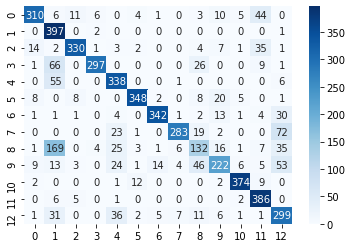

In [63]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues',)

# Submission

## Example

Example needs to have python3 installed

Test to see whether submission with ingestion program is working

In [64]:
!python3 $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

Using input_dir: /Users/md_76s/Desktop/Files/tf_image_data
Using output_dir: /Users/md_76s/Desktop/Files/starting_kit/sample_result_submission
Using program_dir: /Users/md_76s/Desktop/Files/starting_kit/ingestion_program
Using submission_dir: /Users/md_76s/Desktop/Files/starting_kit/sample_code_submission
[+] Done
[+] Overall time spent  6.15 sec ::  Overall time budget  0.00 sec


### Test scoring program

In [65]:
scoring_output_dir = 'scoring_output'
!python3 $score_dir/score.py $data_dir $result_dir $scoring_output_dir

Traceback (most recent call last):
  File "scoring_program//score.py", line 20, in <module>
    import libscores
  File "/Users/md_76s/Desktop/Files/starting_kit/scoring_program/libscores.py", line 30, in <module>
    from scoring_program import my_metric
ModuleNotFoundError: No module named 'scoring_program'


# Prepare the submission

In [66]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './submissions/sample_code_submission_' + the_date + '.zip'
sample_result_submission = './submissions/sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
./submissions/sample_code_submission_20-12-30-20-00.zip
./submissions/sample_result_submission_20-12-30-20-00.zip
